In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Moved import here
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # Corrected import
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: Load and Explore the Dataset

In [ ]:
# Load dataset
df =pd.read_csv("/content/drive/MyDrive/leukemiamicroarray.csv", sep=';')

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nColumn names (first 10):")
print(df.columns[:10].tolist())

print("\nDataset Info:")
print(df.info())

print("\nClass distribution:")
print(df['Leukemia_class'].value_counts())

print("\nBasic statistics:")
print(df.describe())

Dataset Shape: (72, 7130)

First 5 rows:
     Gene_1    Gene_2    Gene_3    Gene_4    Gene_5    Gene_6    Gene_7  \
0  0.494152  0.145161  0.930748  0.937705  0.476117  0.478852  0.697077   
1  0.038012  0.266129  0.342105  0.567213  0.379045  0.818731  0.119575   
2  0.000000  0.141129  0.000000  0.049180  0.000000  0.000000  1.000000   
3  1.000000  1.000000  0.372576  0.796721  0.514638  0.643505  0.000000   
4  0.201754  0.391129  1.000000  0.436066  1.000000  1.000000  0.209035   

     Gene_8    Gene_9   Gene_10  ...  Gene_7121  Gene_7122  Gene_7123  \
0  0.000000  0.858108  0.778739  ...   0.321114   0.000000   0.328170   
1  0.634921  0.378378  0.412855  ...   0.136364   0.704918   0.065828   
2  0.308390  0.293919  0.595797  ...   1.000000   0.402810   0.462730   
3  0.578231  0.000000  0.000000  ...   0.000000   0.494145   0.582769   
4  0.723356  0.243243  0.698393  ...   0.024927   0.257611   0.000000   

   Gene_7124  Gene_7125  Gene_7126  Gene_7127  Gene_7128  Gene_7129  

# Step 2: Data Visualization and Class Distribution

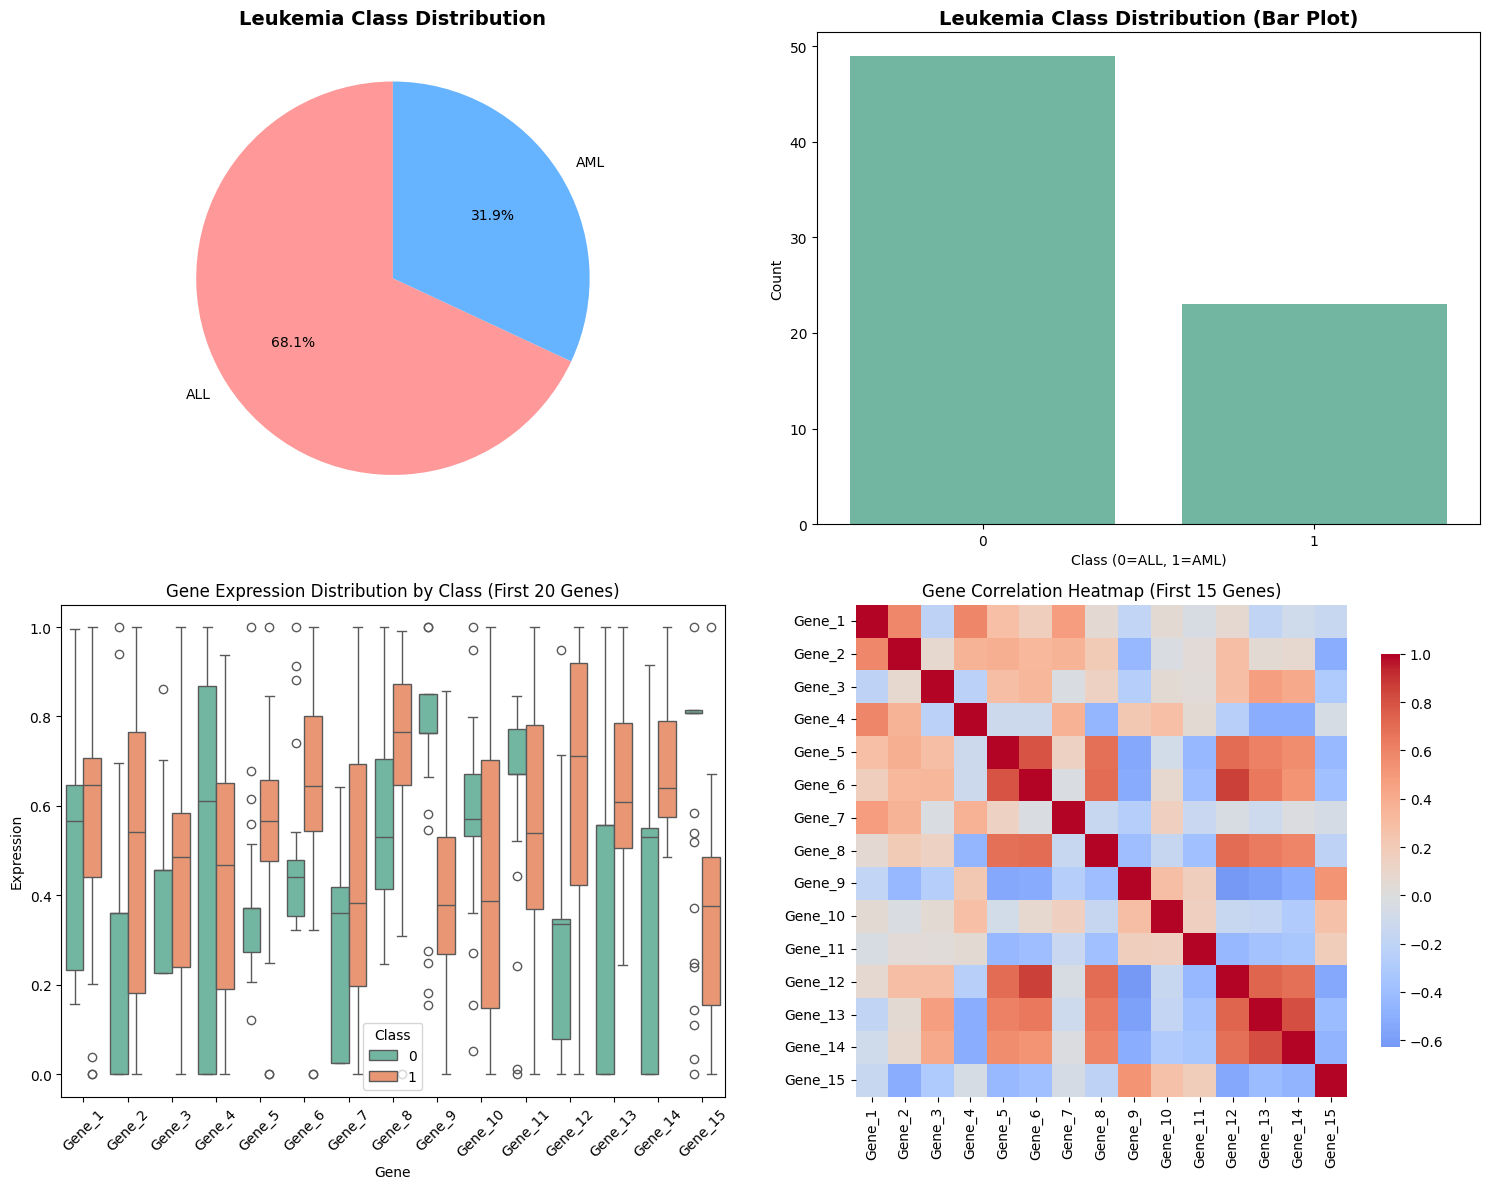


 KEY OBSERVATIONS:
- Total samples: 72
- ALL cases (Class 0): 49 (68.1%)
- AML cases (Class 1): 23 (31.9%)
- Number of genes: 7129
- Class imbalance: Noticeable (68% ALL vs 32% AML)


In [ ]:
# Step 2: Data Visualization
# Set up the plotting style
plt.style.use('default')
sns.set_palette("Set2")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Class distribution pie chart
class_counts = df['Leukemia_class'].value_counts()
class_labels = ['ALL' if x == 0 else 'AML' for x in class_counts.index]
axes[0,0].pie(class_counts.values, labels=class_labels, autopct='%1.1f%%',
              colors=['#ff9999', '#66b3ff'], startangle=90)
axes[0,0].set_title('Leukemia Class Distribution', fontsize=14, fontweight='bold')

# Class distribution bar plot
sns.countplot(data=df, x='Leukemia_class', ax=axes[0,1])
axes[0,1].set_title('Leukemia Class Distribution (Bar Plot)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Class (0=ALL, 1=AML)')
axes[0,1].set_ylabel('Count')

# Distribution of gene expression values (first 15 genes)
gene_columns = df.columns[:15]  # First 15 genes
df_melted = df[list(gene_columns) + ['Leukemia_class']].melt(
    id_vars=['Leukemia_class'],
    var_name='Gene',
    value_name='Expression'
)
sns.boxplot(data=df_melted, x='Gene', y='Expression', hue='Leukemia_class', ax=axes[1,0])
axes[1,0].set_title('Gene Expression Distribution by Class (First 20 Genes)', fontsize=12)
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Class')

# Correlation heatmap of first 15 genes
correlation_matrix = df[gene_columns].corr()
sns.heatmap(correlation_matrix, ax=axes[1,1], cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": .8})
axes[1,1].set_title('Gene Correlation Heatmap (First 15 Genes)', fontsize=12)

plt.tight_layout()
plt.show()

# Print some important observations
print("\n KEY OBSERVATIONS:")
print(f"- Total samples: {len(df)}")
print(f"- ALL cases (Class 0): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
print(f"- AML cases (Class 1): {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")
print(f"- Number of genes: {df.shape[1] - 1}")
print(f"- Class imbalance: Noticeable (68% ALL vs 32% AML)")

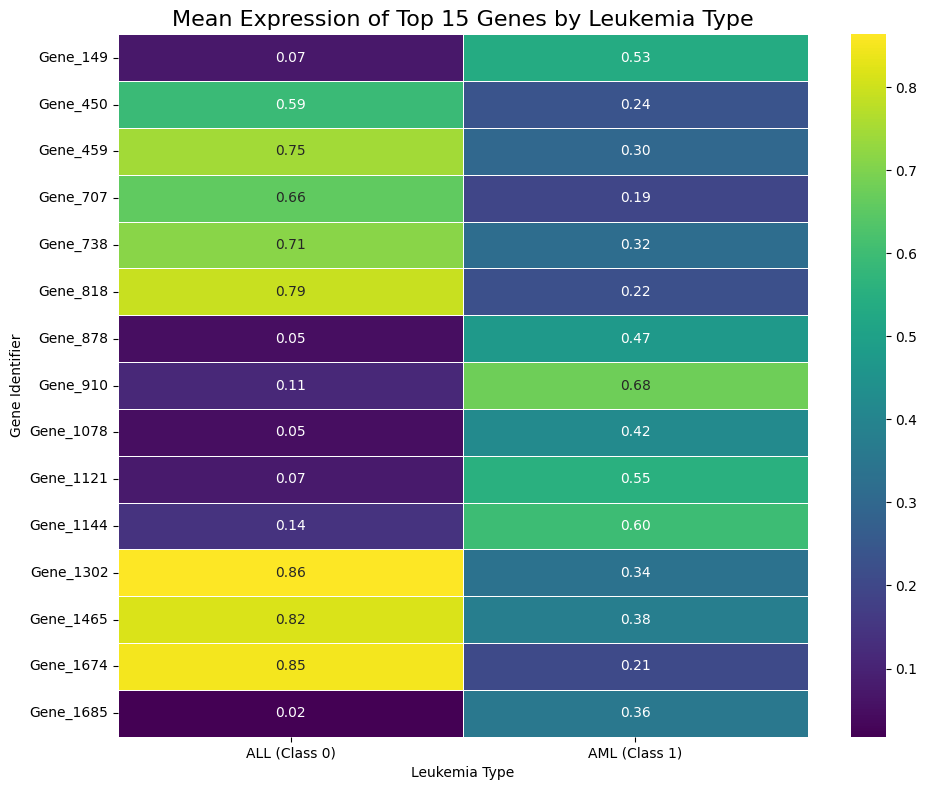

In [ ]:
# List of the top 15 genes you provided
top_15_genes = [
    'Gene_149', 'Gene_450', 'Gene_459', 'Gene_707', 'Gene_738', 'Gene_818',
    'Gene_878', 'Gene_910', 'Gene_1078', 'Gene_1121', 'Gene_1144',
    'Gene_1302', 'Gene_1465', 'Gene_1674', 'Gene_1685'
]

# Calculate the mean expression for each gene, grouped by the leukemia class
mean_expression = df.groupby('Leukemia_class')[top_15_genes].mean().T

# Rename the columns for clarity
mean_expression.columns = ['ALL (Class 0)', 'AML (Class 1)']

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mean_expression, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Mean Expression of Top 15 Genes by Leukemia Type', fontsize=16)
plt.ylabel('Gene Identifier')
plt.xlabel('Leukemia Type')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Step 3: Data Splitting and Preprocessing

Original data shape:
X: (72, 7129), y: (72,)

After splitting:
X_train: (57, 7129)
X_test:  (15, 7129)
y_train: (57,)
y_test:  (15,)

Class distribution in training set:
Leukemia_class
0    39
1    18
Name: count, dtype: int64
Training set class ratio: 39/18

Class distribution in testing set:
Leukemia_class
0    10
1     5
Name: count, dtype: int64
Testing set class ratio: 10/5

After scaling:
X_train_scaled shape: (57, 7129)
X_test_scaled shape:  (15, 7129)
X_train_scaled mean: -0.0000 ± 1.0000
X_test_scaled mean:  0.0268 ± 1.0108


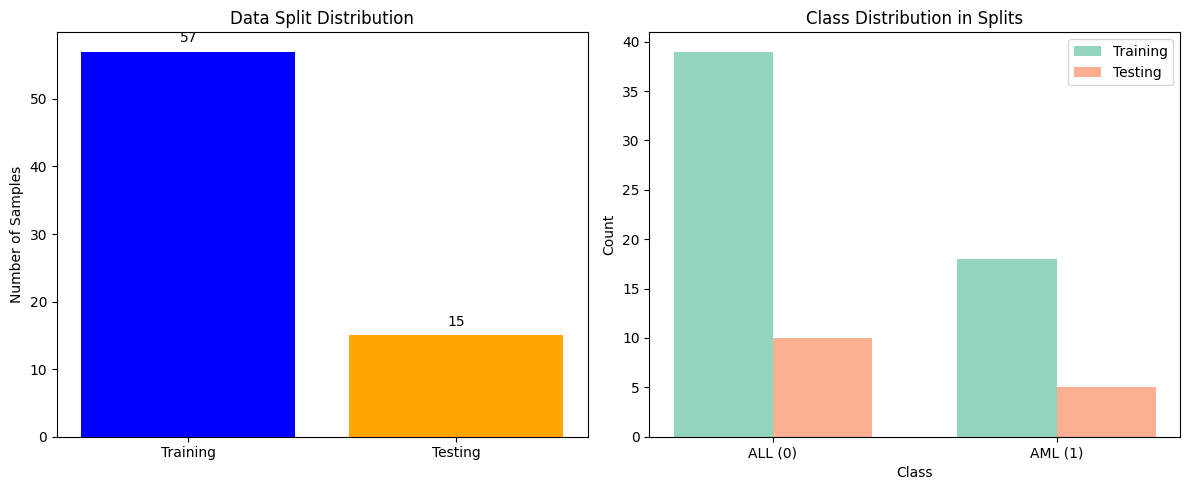

In [ ]:
# Step 3: Data Splitting and Preprocessing

# Prepare the data
X = df.drop(columns=['Leukemia_class'])
y = df['Leukemia_class']

print("Original data shape:")
print(f"X: {X.shape}, y: {y.shape}")

# Split the data (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nAfter splitting:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

# Check class distribution in splits
print(f"\nClass distribution in training set:")
print(y_train.value_counts().sort_index())
print(f"Training set class ratio: {y_train.value_counts()[0]}/{y_train.value_counts()[1]}")

print(f"\nClass distribution in testing set:")
print(y_test.value_counts().sort_index())
print(f"Testing set class ratio: {y_test.value_counts()[0]}/{y_test.value_counts()[1]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nAfter scaling:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape:  {X_test_scaled.shape}")
print(f"X_train_scaled mean: {np.mean(X_train_scaled):.4f} ± {np.std(X_train_scaled):.4f}")
print(f"X_test_scaled mean:  {np.mean(X_test_scaled):.4f} ± {np.std(X_test_scaled):.4f}")

# Visualize the data splitting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
split_data = {
    'Training': len(X_train),
    'Testing': len(X_test)
}
plt.bar(split_data.keys(), split_data.values(), color=['blue', 'orange'])
plt.title('Data Split Distribution')
plt.ylabel('Number of Samples')
for i, v in enumerate(split_data.values()):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()
x = np.arange(2)
width = 0.35

plt.bar(x - width/2, train_counts.values, width, label='Training', alpha=0.7)
plt.bar(x + width/2, test_counts.values, width, label='Testing', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Splits')
plt.xticks(x, ['ALL (0)', 'AML (1)'])
plt.legend()

plt.tight_layout()
plt.show()

# Step 4: Feature Selection - Finding Most Important Genes

Selecting top 100 most important genes...

 Feature selection completed with 3 methods:
   - ANOVA F-test: 100 genes selected
   - Mutual Information: 100 genes selected
   - Random Forest: 100 genes selected

 Comparing feature selection methods with 5-fold cross-validation:
   ANOVA F-test: 1.0000 ± 0.0000
   Mutual Information: 1.0000 ± 0.0000
   Random Forest: 1.0000 ± 0.0000

 Best method: ANOVA F-test (Accuracy: 1.0000)

 Final selected data shapes:
   X_train_final: (57, 100)
   X_test_final:  (15, 100)

 Top 100 genes selected by ANOVA F-test:
['Gene_149', 'Gene_450', 'Gene_459', 'Gene_707', 'Gene_738', 'Gene_818', 'Gene_878', 'Gene_910', 'Gene_1078', 'Gene_1092', 'Gene_1121', 'Gene_1144', 'Gene_1465', 'Gene_1525', 'Gene_1615', 'Gene_1674', 'Gene_1685', 'Gene_1725', 'Gene_1745', 'Gene_1913', 'Gene_1928', 'Gene_1945', 'Gene_2015', 'Gene_2020', 'Gene_2043', 'Gene_2063', 'Gene_2110', 'Gene_2123', 'Gene_2288', 'Gene_2335', 'Gene_2394', 'Gene_2546', 'Gene_2589', 'Gene_2607', 'Gene_2

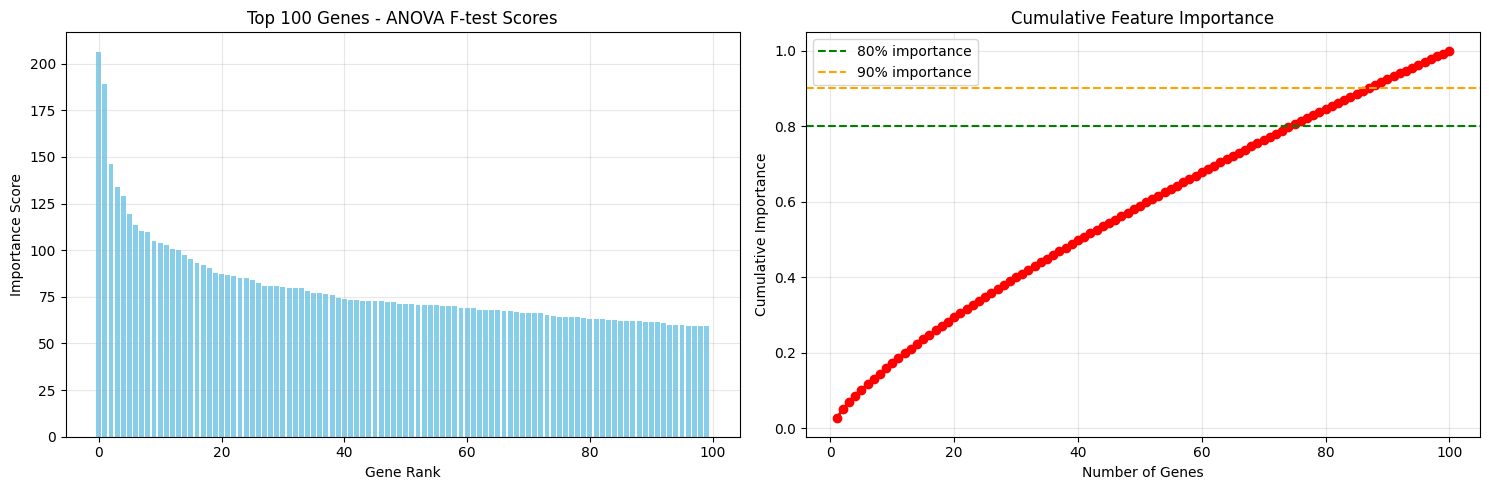

In [ ]:
# Step 4: Feature Selection
# We'll try different methods to select top genes
n_top_genes = 100  # Select top 50 most important genes

print(f"Selecting top {n_top_genes} most important genes...")

# Method 1: ANOVA F-test
selector_anova = SelectKBest(score_func=f_classif, k=n_top_genes)
X_train_anova = selector_anova.fit_transform(X_train_scaled, y_train)
X_test_anova = selector_anova.transform(X_test_scaled)

# Method 2: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=n_top_genes)
X_train_mi = selector_mi.fit_transform(X_train_scaled, y_train)
X_test_mi = selector_mi.transform(X_test_scaled)

# Method 3: Random Forest Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
importances = rf.feature_importances_
top_indices_rf = np.argsort(importances)[-n_top_genes:][::-1]
X_train_rf = X_train_scaled[:, top_indices_rf]
X_test_rf = X_test_scaled[:, top_indices_rf]

print(f"\n Feature selection completed with 3 methods:")
print(f"   - ANOVA F-test: {X_train_anova.shape[1]} genes selected")
print(f"   - Mutual Information: {X_train_mi.shape[1]} genes selected")
print(f"   - Random Forest: {X_train_rf.shape[1]} genes selected")

# Compare the methods using a simple classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

methods = {
    'ANOVA F-test': (X_train_anova, X_test_anova),
    'Mutual Information': (X_train_mi, X_test_mi),
    'Random Forest': (X_train_rf, X_test_rf)
}

print(f"\n Comparing feature selection methods with 5-fold cross-validation:")

best_method = None
best_score = 0
method_scores = {}

for method_name, (X_train_sel, X_test_sel) in methods.items():
    lr = LogisticRegression(max_iter=1000, random_state=42)
    scores = cross_val_score(lr, X_train_sel, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    method_scores[method_name] = mean_score

    print(f"   {method_name}: {mean_score:.4f} ± {scores.std():.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_method = method_name
        best_data = (X_train_sel, X_test_sel)

print(f"\n Best method: {best_method} (Accuracy: {best_score:.4f})")

# Use the best method for our final data
X_train_final, X_test_final = best_data

print(f"\n Final selected data shapes:")
print(f"   X_train_final: {X_train_final.shape}")
print(f"   X_test_final:  {X_test_final.shape}")

# Get the names of the top genes from the best method
if best_method == 'ANOVA F-test':
    selected_features_indices = selector_anova.get_support(indices=True)
    feature_names = X.columns[selected_features_indices]
    print(f"\n Top {n_top_genes} genes selected by {best_method}:")
    print(feature_names.tolist())
elif best_method == 'Mutual Information':
    selected_features_indices = selector_mi.get_support(indices=True)
    feature_names = X.columns[selected_features_indices]
    print(f"\n Top {n_top_genes} genes selected by {best_method}:")
    print(feature_names.tolist())
else:  # Random Forest
    feature_names = X.columns[top_indices_rf]
    print(f"\n Top {n_top_genes} genes selected by {best_method}:")
    print(feature_names.tolist())

# Display the top 15 genes
print(f"\n Top 15 genes:")
print(feature_names[:15].tolist())


# Visualize feature importance from the best method
plt.figure(figsize=(15, 5))

if best_method == 'ANOVA F-test':
    scores = selector_anova.scores_
    top_indices = np.argsort(scores)[-n_top_genes:][::-1]
    top_scores = scores[top_indices]
    method_name_plot = "ANOVA F-test Scores"
elif best_method == 'Mutual Information':
    scores = selector_mi.scores_
    top_indices = np.argsort(scores)[-n_top_genes:][::-1]
    top_scores = scores[top_indices]
    method_name_plot = "Mutual Information Scores"
else:  # Random Forest
    top_scores = importances[top_indices_rf]
    method_name_plot = "Random Forest Importance"

plt.subplot(1, 2, 1)
plt.bar(range(len(top_scores)), top_scores, color='skyblue')
plt.title(f'Top {n_top_genes} Genes - {method_name_plot}')
plt.xlabel('Gene Rank')
plt.ylabel('Importance Score')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show cumulative importance
sorted_scores = np.sort(top_scores)[::-1]
cumulative_importance = np.cumsum(sorted_scores) / np.sum(sorted_scores)
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'ro-', linewidth=2)
plt.axhline(y=0.8, color='green', linestyle='--', label='80% importance')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% importance')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Genes')
plt.ylabel('Cumulative Importance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

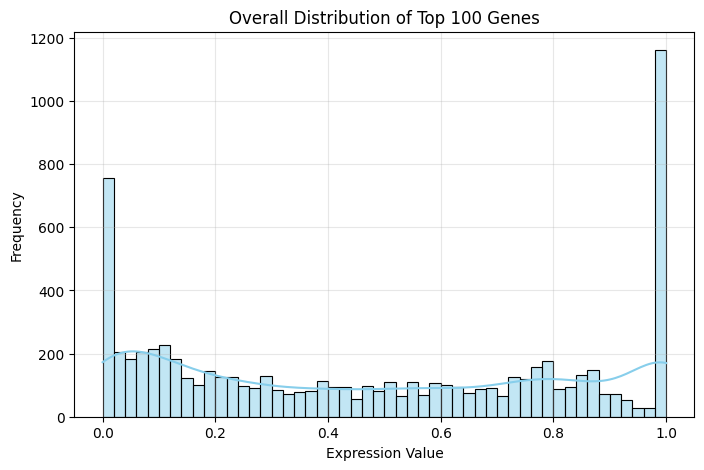

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all selected gene values into a single array
combined_values = X[feature_names].values.flatten()

plt.figure(figsize=(8, 5))
sns.histplot(combined_values, kde=True, bins=50, color="skyblue")
plt.title("Overall Distribution of Top 100 Genes")
plt.xlabel("Expression Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

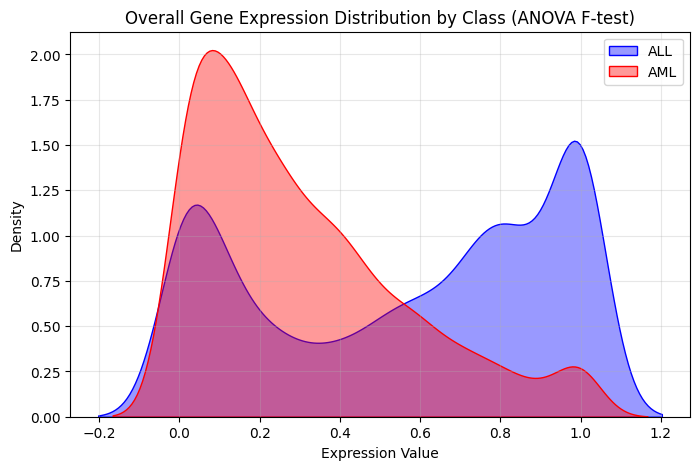

In [ ]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df[df['Leukemia_class'] == 0][feature_names].values.flatten(),
            label='ALL', color='blue', fill=True, alpha=0.4)
sns.kdeplot(data=df[df['Leukemia_class'] == 1][feature_names].values.flatten(),
            label='AML', color='red', fill=True, alpha=0.4)
plt.title(f"Overall Gene Expression Distribution by Class ({best_method})")
plt.xlabel("Expression Value")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

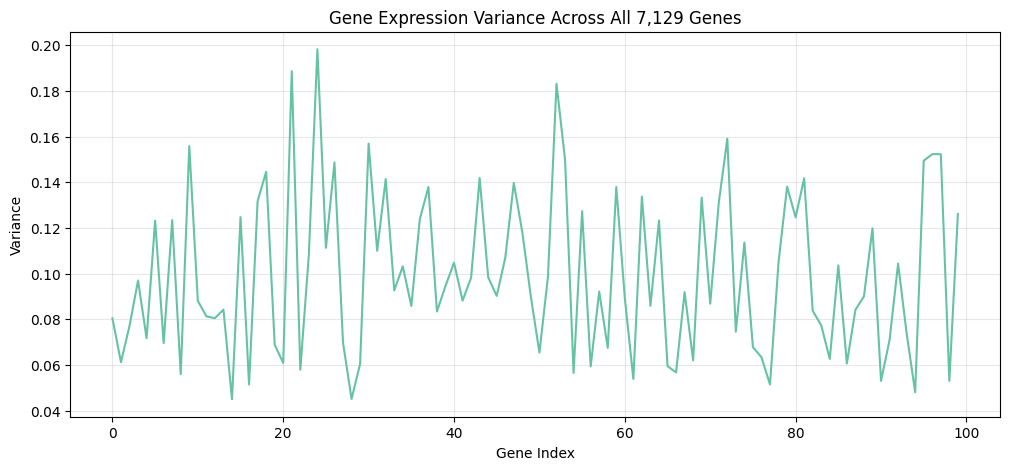

In [ ]:
gene_variances = X[feature_names].var(axis=0)   # X is your gene-expression dataframe

plt.figure(figsize=(12, 5))
plt.plot(gene_variances.values)
plt.title("Gene Expression Variance Across All 7,129 Genes")
plt.xlabel("Gene Index")
plt.ylabel("Variance")
plt.grid(alpha=0.3)
plt.show()

# Step 5: Build the Neural Network

✅ Neural Network Created Successfully!

📋 MODEL ARCHITECTURE:
   Input neurons: 100 (number of selected genes)
   Hidden layers: 3
   Neurons per hidden layer: 10
   Output neurons: 1 (binary classification)
   Activation functions: relu for hidden layers, Sigmoid for output
   Loss function: Binary cross-entropy
   Optimizer: Adam

📊 MODEL SUMMARY:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,241 (4.85 KB)

 Trainable params: 1,241 (4.85 KB)

 Non-trainable params: 0 (0.00 B)

📈 Model architecture visualization saved as 'model_architecture.png'


<Figure size 1000x600 with 0 Axes>

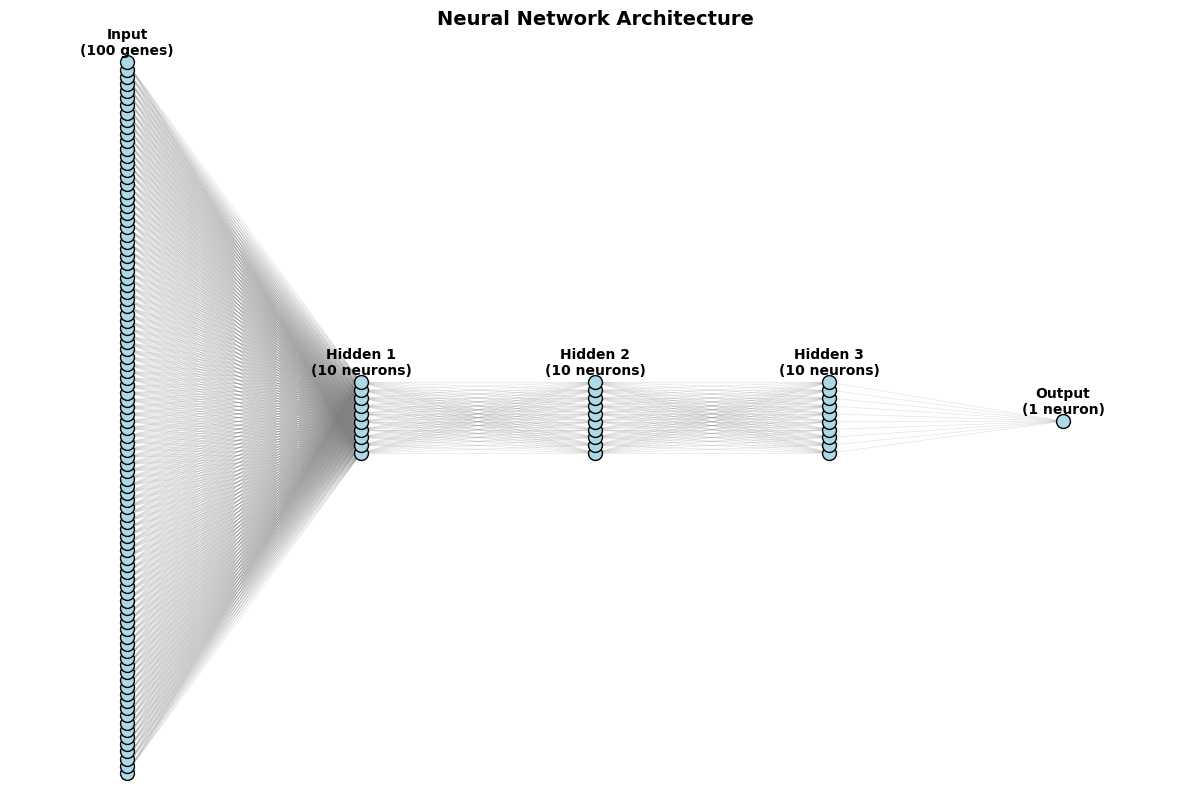

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Step 5: Neural Network Architecture
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create the neural network model (following Neural Designer architecture)
def create_leukemia_model(input_dim, hidden_neurons=10):
    model = keras.Sequential([
        # Input layer
        layers.Dense(hidden_neurons, activation='relu', input_shape=(input_dim,),
                    name='hidden_layer_1'),

        # First hidden layer
        layers.Dense(hidden_neurons, activation='relu', name='hidden_layer_2'),

        # Second hidden layer
        layers.Dense(hidden_neurons, activation='relu', name='hidden_layer_3'),

        # Output layer (binary classification - sigmoid for probability)
        layers.Dense(1, activation='sigmoid', name='output_layer') # Corrected activation to sigmoid
    ])

    return model

# Create the model
input_dim = X_train_final.shape[1]
model = create_leukemia_model(input_dim, hidden_neurons=10)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("✅ Neural Network Created Successfully!")
print(f"\n📋 MODEL ARCHITECTURE:")
print(f"   Input neurons: {input_dim} (number of selected genes)")
print(f"   Hidden layers: 3")
print(f"   Neurons per hidden layer: 10")
print(f"   Output neurons: 1 (binary classification)")
print(f"   Activation functions: relu for hidden layers, Sigmoid for output") # Updated description
print(f"   Loss function: Binary cross-entropy")
print(f"   Optimizer: Adam")

# Display model summary
print(f"\n📊 MODEL SUMMARY:")
model.summary()

# Visualize the model architecture
try:
    from tensorflow.keras.utils import plot_model
    plt.figure(figsize=(10, 6))
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("📈 Model architecture visualization saved as 'model_architecture.png'")
except:
    print("ℹ️  Could not generate model visualization diagram")

# Plot a simple representation of the network
plt.figure(figsize=(12, 8))

# Network architecture visualization
layer_neurons = [input_dim, 10, 10, 10, 1]  # Input, 3 hidden, output
layer_names = ['Input\n(100 genes)', 'Hidden 1\n(10 neurons)', 'Hidden 2\n(10 neurons)',
               'Hidden 3\n(10 neurons)', 'Output\n(1 neuron)']

for i, neurons in enumerate(layer_neurons):
    y_positions = np.linspace(-neurons/2, neurons/2, neurons)
    for j in range(neurons):
        plt.scatter(i, y_positions[j], s=100, c='lightblue', edgecolors='black', zorder=3)

    # Add layer label
    plt.text(i, max(y_positions) + 1, layer_names[i], ha='center', fontweight='bold', fontsize=10)

    # Draw connections between layers
    if i < len(layer_neurons) - 1:
        next_neurons = layer_neurons[i + 1]
        next_y_positions = np.linspace(-next_neurons/2, next_neurons/2, next_neurons)
        for j in range(neurons):
            for k in range(next_neurons):
                plt.plot([i, i+1], [y_positions[j], next_y_positions[k]], 'gray', alpha=0.2, linewidth=0.5)

plt.xlim(-0.5, len(layer_neurons) - 0.5)
plt.ylim(-max(layer_neurons)/2 - 1, max(layer_neurons)/2 + 1)
plt.title('Neural Network Architecture\n', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Step 6: Training Strategy Implementation

📊 Final data split for training:
   Training samples: 45
   Validation samples: 12
   Testing samples: 15

🎯 Training Strategy:
   - Optimizer: Adam (adaptive learning rate)
   - Learning rate: Starts at 0.001, reduces on plateau
   - Batch size: 32
   - Maximum epochs: 200
   - Early stopping: Patience of 20 epochs
   - Loss monitoring: Validation loss

🚀 Starting training...
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step - accuracy: 0.3220 - loss: 1.0880 - precision: 0.3220 - recall: 1.0000 - val_accuracy: 0.3333 - val_loss: 0.9139 - val_precision: 0.3333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3220 - loss: 0.9921 - precision: 0.3220 - recall: 1.0000 - val_accuracy: 0.3333 - val_loss: 0.8237 - val_precision: 0.3333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3220 - loss: 0.9050 - precision: 0.3220 - recall: 1.0000 - val_accuracy: 0.3333 - val_loss

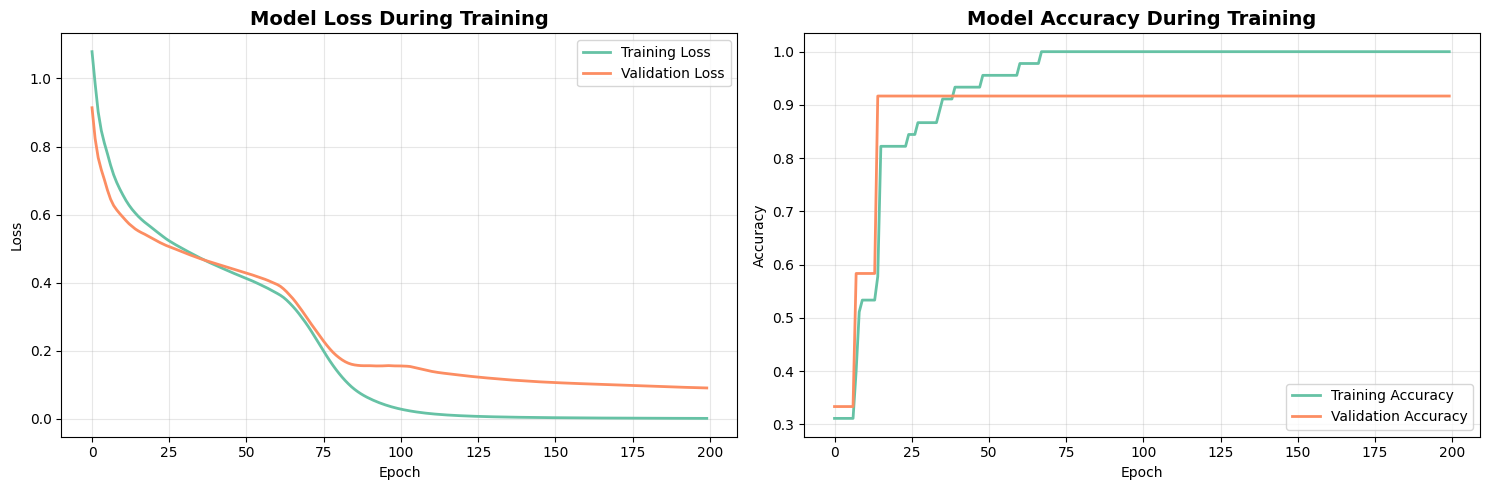


📊 FINAL TRAINING RESULTS:
   Training completed in 200 epochs
   Final Training Loss: 0.0015
   Final Validation Loss: 0.0909
   Final Training Accuracy: 1.0000
   Final Validation Accuracy: 0.9167
   ✅ Training completed all 200 epochs


In [ ]:
# Step 6: Training Strategy
# First, let's split the training data further for validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_final, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("📊 Final data split for training:")
print(f"   Training samples: {X_train_final.shape[0]}")
print(f"   Validation samples: {X_val.shape[0]}")
print(f"   Testing samples: {X_test_final.shape[0]}")

print(f"\n🎯 Training Strategy:")
print(f"   - Optimizer: Adam (adaptive learning rate)")
print(f"   - Learning rate: Starts at 0.001, reduces on plateau")
print(f"   - Batch size: 32")
print(f"   - Maximum epochs: 200")
print(f"   - Early stopping: Patience of 20 epochs")
print(f"   - Loss monitoring: Validation loss")

# Define callbacks for training strategy
callbacks = [
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),

    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
]

print(f"\n🚀 Starting training...")

# Train the model
history = model.fit(
    X_train_final, y_train_final,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print(f"\n✅ Training completed!")

# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy During Training', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display final training results
final_epoch = len(history.history['loss'])
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\n📊 FINAL TRAINING RESULTS:")
print(f"   Training completed in {final_epoch} epochs")
print(f"   Final Training Loss: {final_train_loss:.4f}")
print(f"   Final Validation Loss: {final_val_loss:.4f}")
print(f"   Final Training Accuracy: {final_train_acc:.4f}")
print(f"   Final Validation Accuracy: {final_val_acc:.4f}")

# Check if early stopping was triggered
if final_epoch < 200:
    print(f"   ⏹️  Early stopping triggered at epoch {final_epoch}")
else:
    print(f"   ✅ Training completed all 200 epochs")

# Step 7: Model Evaluation on Test Set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Test set predictions completed:
  Test samples: 15
  Predictions shape: (15, 1)
  True labels: [0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
  Predicted labels: [0 0 1 0 1 0 0 0 1 1 1 0 1 0 0]

📊 TEST SET PERFORMANCE METRICS:
   Test Accuracy:  0.9333
   Test Precision: 0.8333
   Test Recall:    1.0000
   Test AUC-ROC:   1.0000
   Test F1-Score:  0.9091

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     ALL (0)       1.00      0.90      0.95        10
     AML (1)       0.83      1.00      0.91         5

    accuracy                           0.93        15
   macro avg       0.92      0.95      0.93        15
weighted avg       0.94      0.93      0.93        15



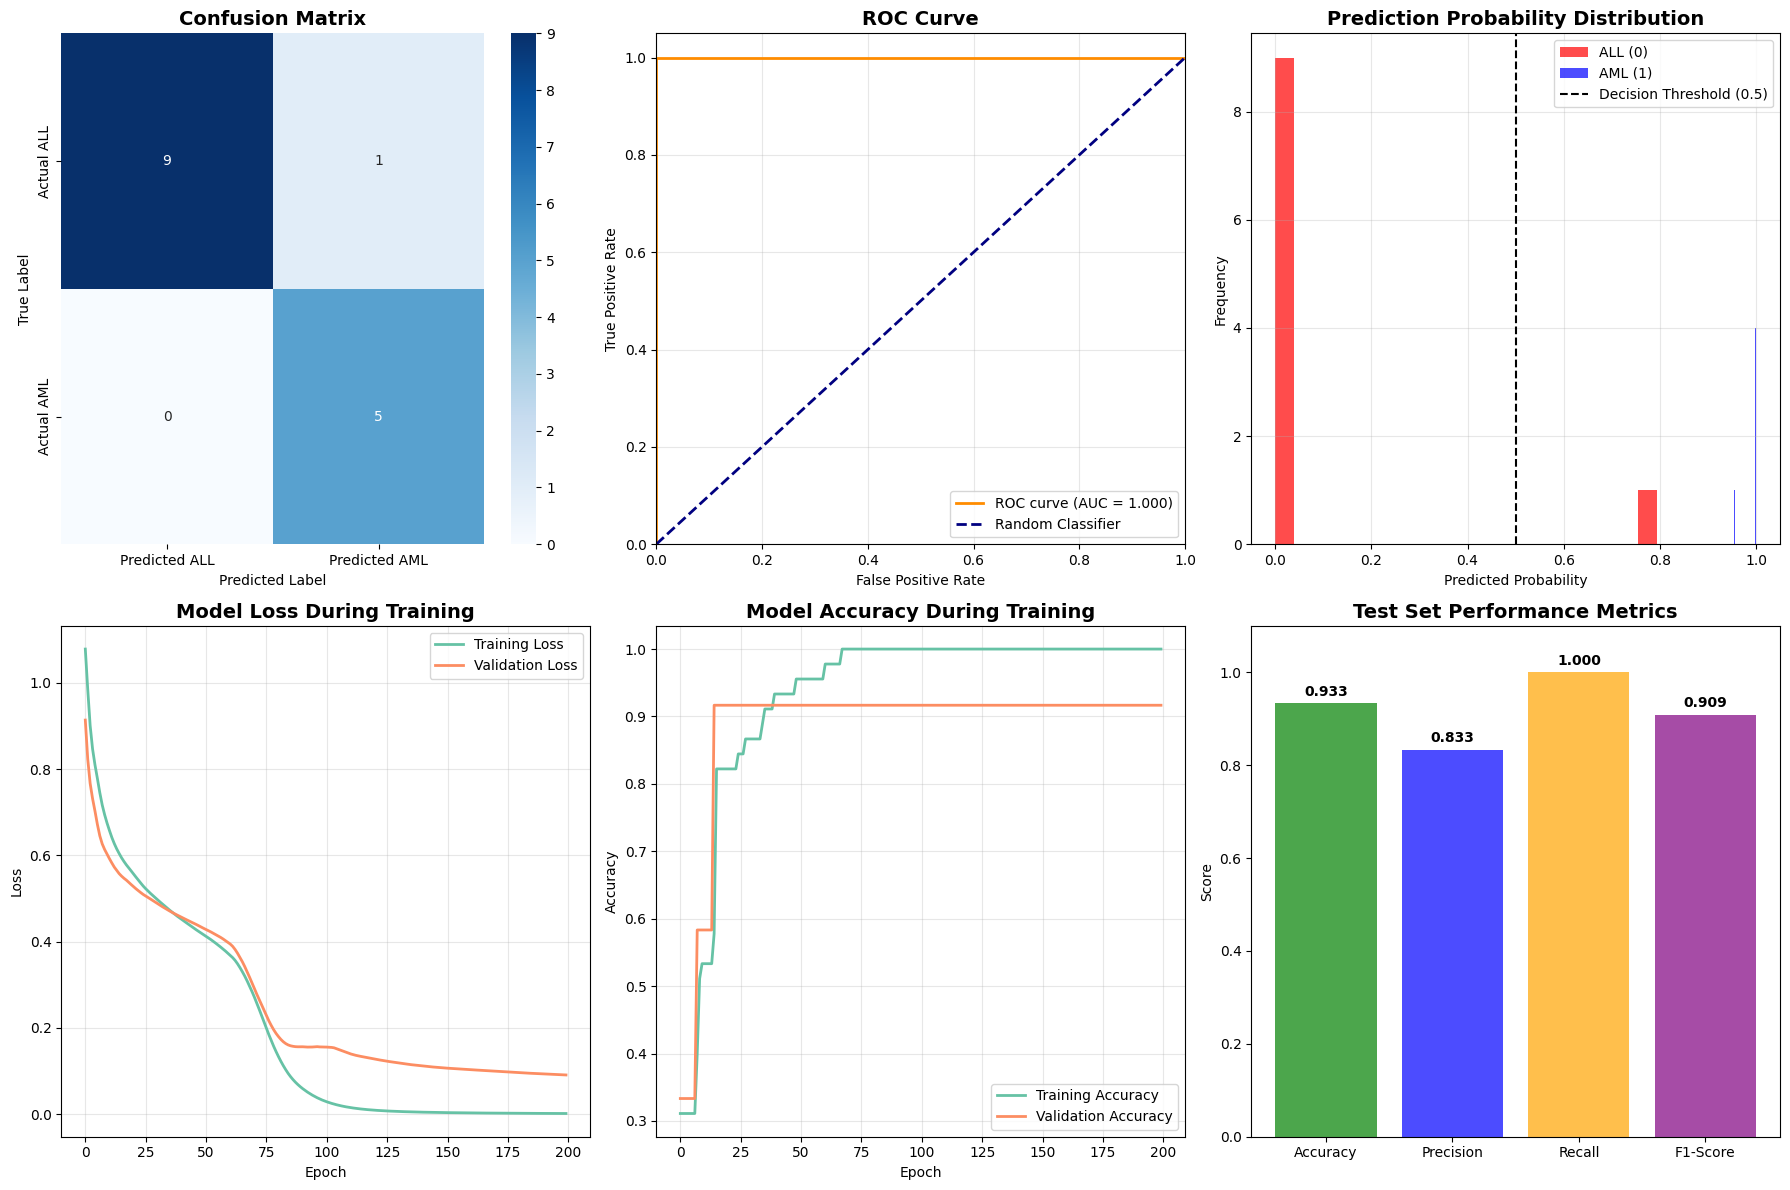


🎯 OVERALL PERFORMANCE SUMMARY:
   ✅ Training Accuracy:   1.0000
   ✅ Validation Accuracy: 0.9167
   ✅ Test Accuracy:       0.9333
   🎉 EXCELLENT: Model achieved high accuracy on test set!


In [ ]:
# Step 7: Test Set Evaluation (Fixed)
# Make predictions on the test set
y_pred_proba = model.predict(X_test_final)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Convert test labels to proper format
y_test_binary = y_test.values if hasattr(y_test, 'values') else y_test
y_test_binary = y_test_binary.astype(np.float32)  # Ensure proper data type

print(f"Test set predictions completed:")
print(f"  Test samples: {len(y_test_binary)}")
print(f"  Predictions shape: {y_pred_proba.shape}")
print(f"  True labels: {y_test_binary}")
print(f"  Predicted labels: {y_pred}")

# Calculate accuracy manually to avoid the evaluate() issue
test_accuracy = np.mean(y_pred == y_test_binary)

# Calculate precision and recall manually
from sklearn.metrics import precision_score, recall_score
test_precision = precision_score(y_test_binary, y_pred, zero_division=0)
test_recall = recall_score(y_test_binary, y_pred, zero_division=0)

print("\n📊 TEST SET PERFORMANCE METRICS:")
print(f"   Test Accuracy:  {test_accuracy:.4f}")
print(f"   Test Precision: {test_precision:.4f}")
print(f"   Test Recall:    {test_recall:.4f}")

# Calculate additional metrics
try:
    test_auc = roc_auc_score(y_test_binary, y_pred_proba)
    print(f"   Test AUC-ROC:   {test_auc:.4f}")
except Exception as e:
    test_auc = None
    print(f"   Test AUC-ROC:   Could not calculate ({str(e)})")

# Calculate F1-score
from sklearn.metrics import f1_score
test_f1 = f1_score(y_test_binary, y_pred, zero_division=0)
print(f"   Test F1-Score:  {test_f1:.4f}")

# Classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test_binary, y_pred, target_names=['ALL (0)', 'AML (1)']))

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Predicted ALL', 'Predicted AML'],
            yticklabels=['Actual ALL', 'Actual AML'])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Predicted Label')
axes[0,0].set_ylabel('True Label')

# 2. ROC Curve
if test_auc is not None:
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True, alpha=0.3)
else:
    axes[0,1].text(0.5, 0.5, 'ROC Curve\nNot Available', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')

# 3. Prediction Distribution
axes[0,2].hist(y_pred_proba[y_test_binary == 0], alpha=0.7, label='ALL (0)', bins=20, color='red')
axes[0,2].hist(y_pred_proba[y_test_binary == 1], alpha=0.7, label='AML (1)', bins=20, color='blue')
axes[0,2].axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold (0.5)')
axes[0,2].set_xlabel('Predicted Probability')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Training History - Loss
axes[1,0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1,0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1,0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Training History - Accuracy
axes[1,1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1,1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1,1].set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Performance Summary
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_accuracy, test_precision, test_recall, test_f1]
colors = ['green', 'blue', 'orange', 'purple']

bars = axes[1,2].bar(metrics, values, color=colors, alpha=0.7)
axes[1,2].set_title('Test Set Performance Metrics', fontsize=14, fontweight='bold')
axes[1,2].set_ylabel('Score')
axes[1,2].set_ylim(0, 1.1)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1,2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Performance summary
print(f"\n🎯 OVERALL PERFORMANCE SUMMARY:")
print(f"   ✅ Training Accuracy:   {history.history['accuracy'][-1]:.4f}")
print(f"   ✅ Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"   ✅ Test Accuracy:       {test_accuracy:.4f}")

if test_accuracy >= 0.90:
    print(f"   🎉 EXCELLENT: Model achieved high accuracy on test set!")
elif test_accuracy >= 0.80:
    print(f"   👍 GOOD: Model performed well on test set!")
else:
    print(f"   ⚠️  MODERATE: Consider further model tuning")